In [ ]:
# ------IMPORTS------

import scipy.io
import h5py
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [1]:
# ------MOUNT GOOGLE DRIVE------

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ------DATA PROCESSING FUNCTION------


def process_data_with_noise(file_path, label, segment_size=12000, num_segments=20, noise_std = 0.1):

  try:
    mat_data = scipy.io.loadmat(file_path)
    signal_key = [key for key in mat_data.keys() if 'DE_time' in key][0]
    signal = mat_data[signal_key].flatten()

  except (NotImplementedError, ValueError):
    with h5py.File(file_path, 'r') as mat_file:
        signal_key = [key for key in mat_file.keys() if 'DE_time' in key][0]
        signal = np.array(mat_file[signal_key]).flatten()

  noise =np.random.normal(0, noise_std * np.std(signal), len(signal))
  signal_noise = signal + noise

  segments = []
  for i in range(0, min(len(signal) - segment_size, segment_size * num_segments), segment_size): #range(start,stop,step)
    segment = signal[i : i + segment_size]
    segments.append(segment)

  features = []
  for segment in segments:
    mean_value = np.mean(segment)
    std_value = np.std(segment)
    rms_value = np.sqrt(np.mean(segment ** 2))
    max_value = np.max(segment)
    min_value = np.min(segment)
    skew_value = skew(segment)
    kurtosis_value = kurtosis(segment)
    p2p_value = np.ptp(segment)
    crest_factor = np.max(np.abs(segment)) / rms_value
    shape_factor = rms_value / np.mean(np.abs(segment))

    features.append([mean_value, std_value, rms_value, max_value, min_value, skew_value, kurtosis_value, p2p_value, crest_factor, shape_factor])

  df = pd.DataFrame(features, columns=['Mean', 'Std', 'RMS', 'Max', 'Min', 'Skew', 'Kurtosis', 'P2P', 'CrestFactor', 'ShapeFactor'])
  df['Label'] = label

  return df



In [4]:
# ------LOAD DATA------


df_normal = process_data_with_noise('/content/drive/MyDrive/AI_Project/Data/97_Normal.mat', 'Normal')
df_outer = process_data_with_noise('/content/drive/MyDrive/AI_Project/Data/130_Outer_Race.mat', 'Outer')
df_ball = process_data_with_noise('/content/drive/MyDrive/AI_Project/Data/118_Ball.mat', 'Ball')
df_inner = process_data_with_noise('/content/drive/MyDrive/AI_Project/Data/105_Inner_Race.mat', 'Inner')

df_normal.to_csv('/content/drive/MyDrive/AI_Project/Data/97.csv', index=False)
df_outer.to_csv('/content/drive/MyDrive/AI_Project/Data/130_Outer_Race.csv', index=False)
df_ball.to_csv('/content/drive/MyDrive/AI_Project/Data/118_Ball.csv', index=False)
df_inner.to_csv('/content/drive/MyDrive/AI_Project/Data/105_Inner_Race.csv', index=False)

df_all = pd.concat([df_normal, df_outer, df_ball, df_inner], ignore_index=True)
df_all.to_csv('/content/drive/MyDrive/AI_Project/Data/all_data.csv', index=False)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Mean         50 non-null     float64
 1   Std          50 non-null     float64
 2   RMS          50 non-null     float64
 3   Max          50 non-null     float64
 4   Min          50 non-null     float64
 5   Skew         50 non-null     float64
 6   Kurtosis     50 non-null     float64
 7   P2P          50 non-null     float64
 8   CrestFactor  50 non-null     float64
 9   ShapeFactor  50 non-null     float64
 10  Label        50 non-null     object 
dtypes: float64(10), object(1)
memory usage: 4.4+ KB
Label
Normal    20
Outer     10
Ball      10
Inner     10
Name: count, dtype: int64
['Normal' 'Outer' 'Ball' 'Inner']


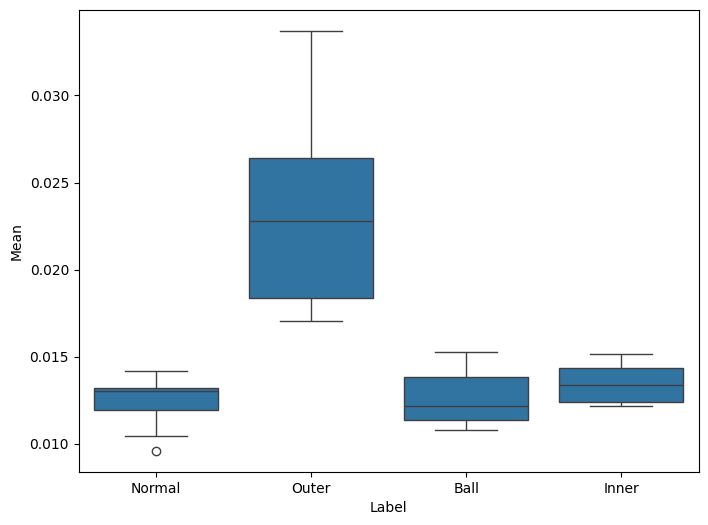

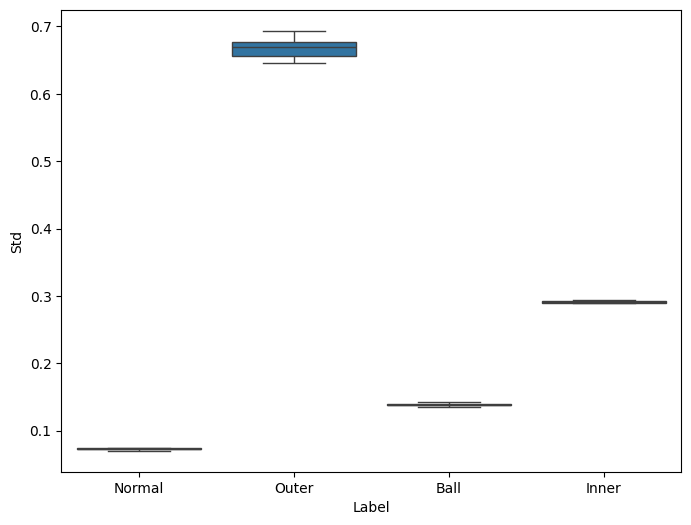

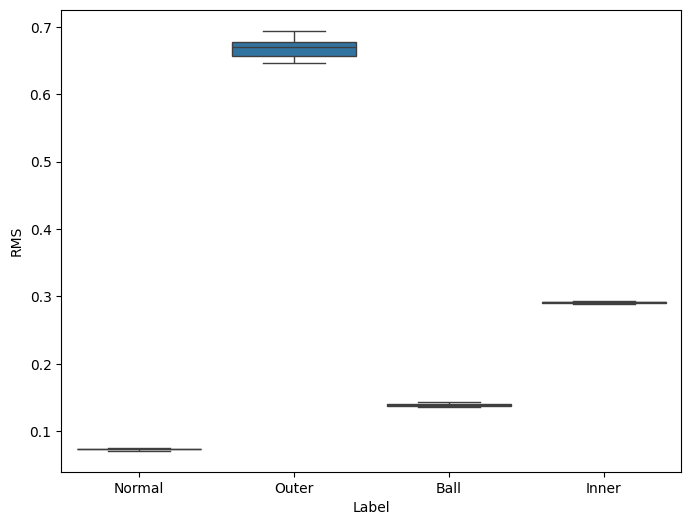

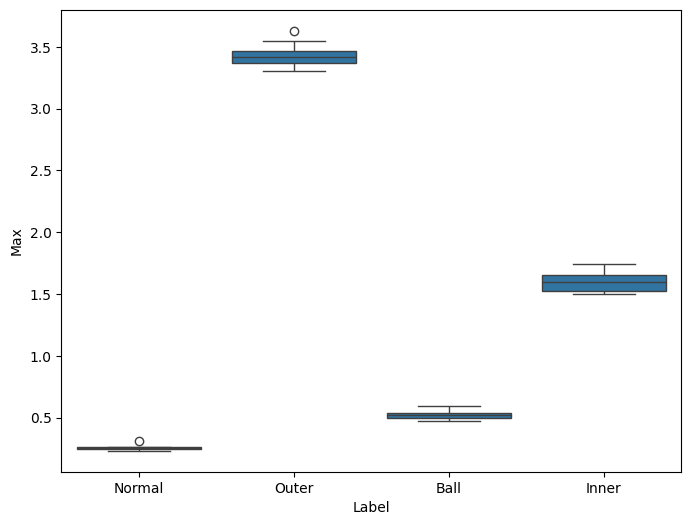

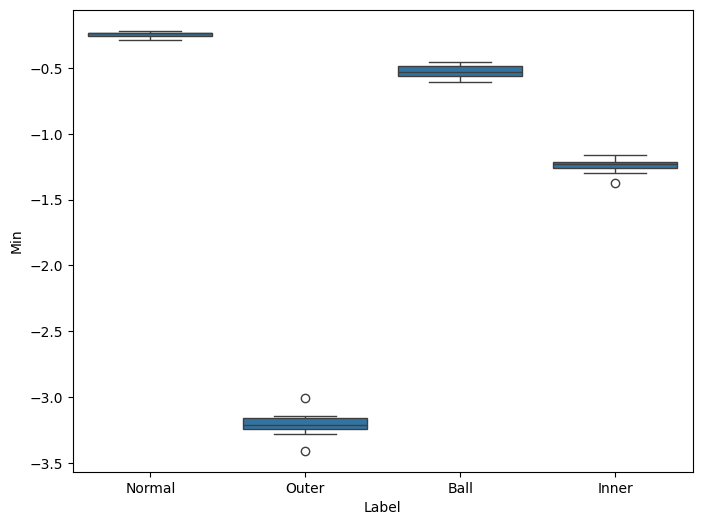

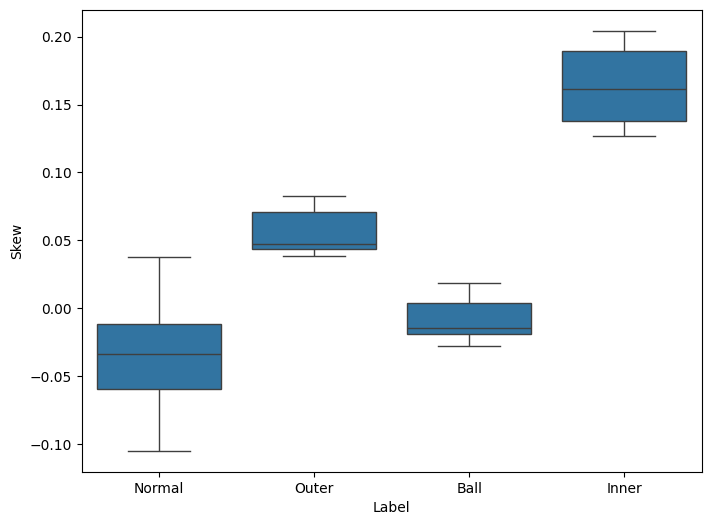

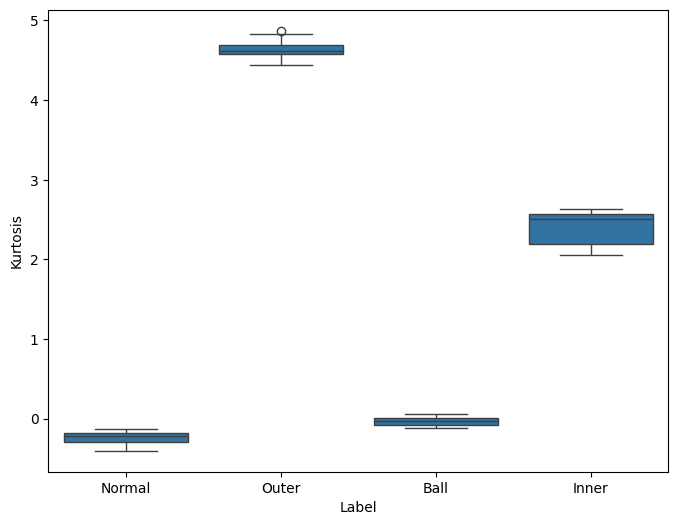

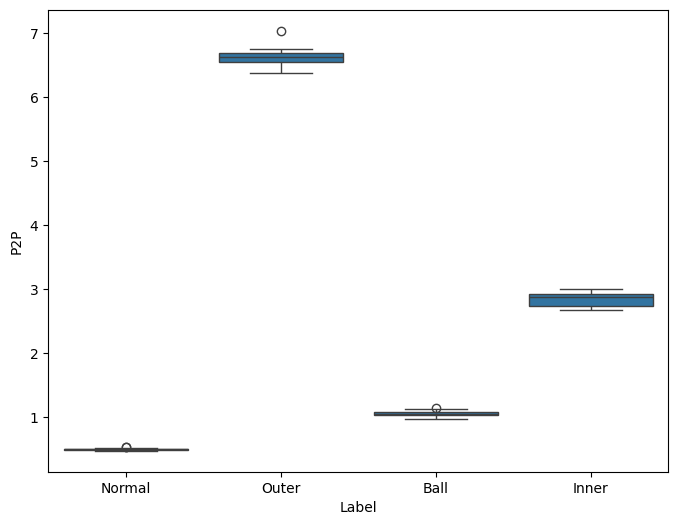

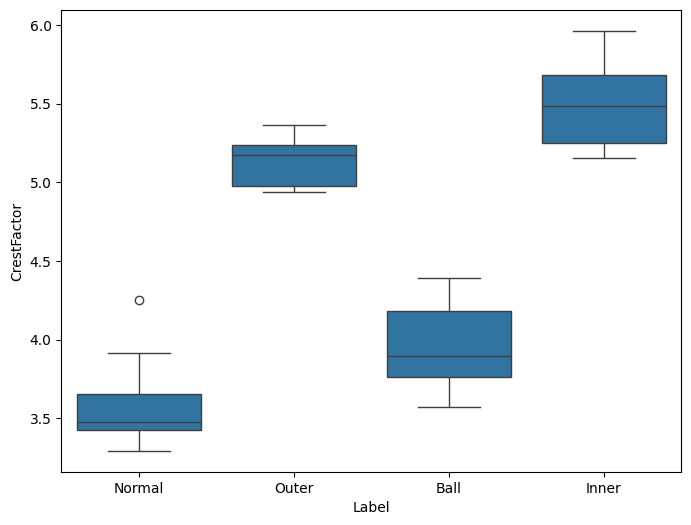

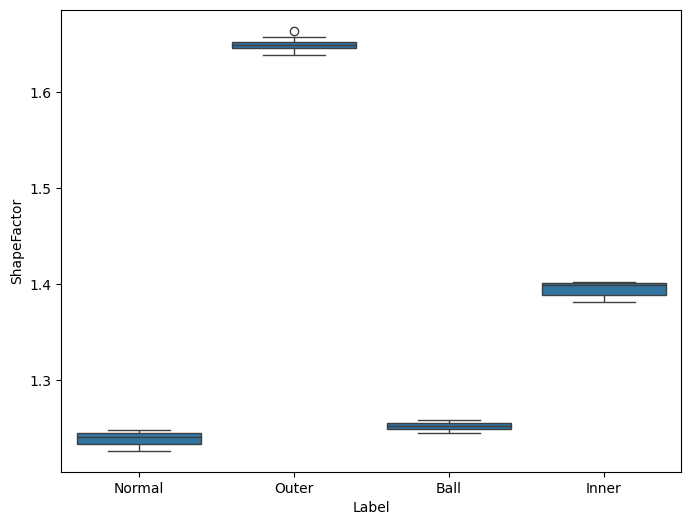

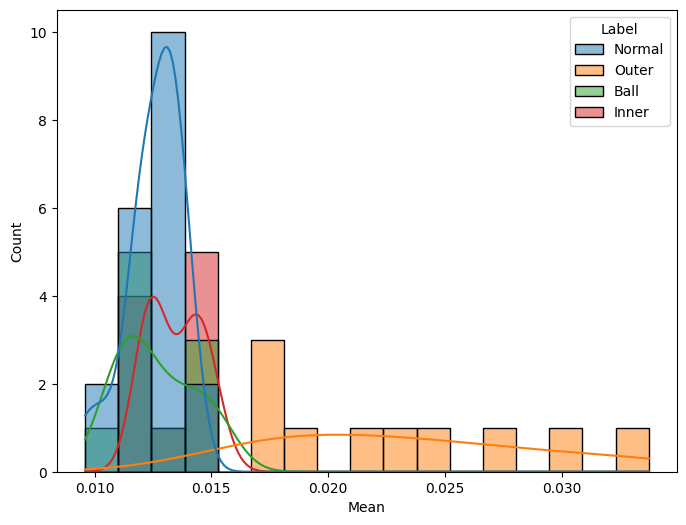

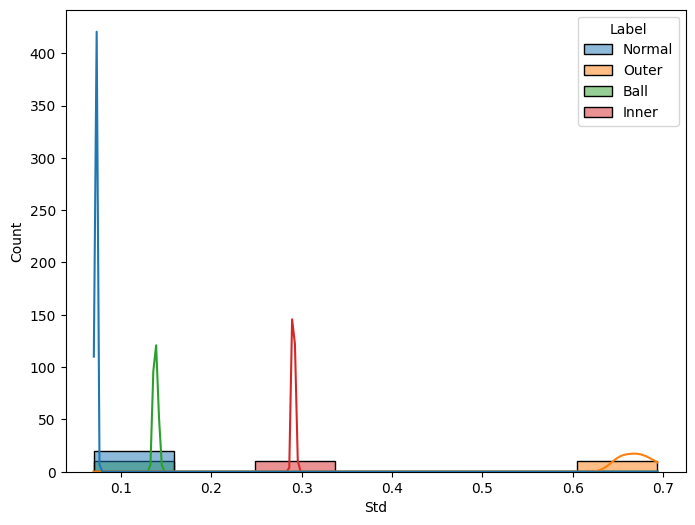

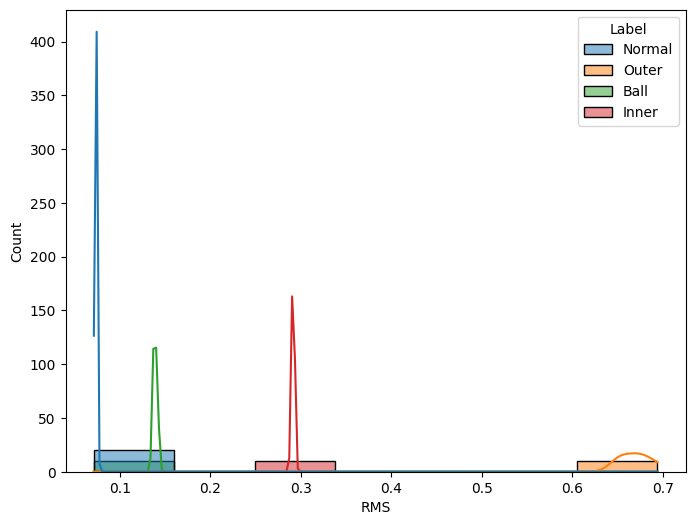

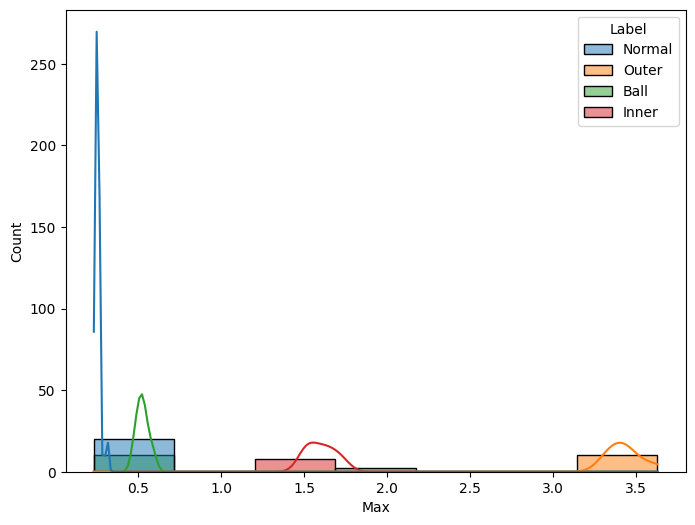

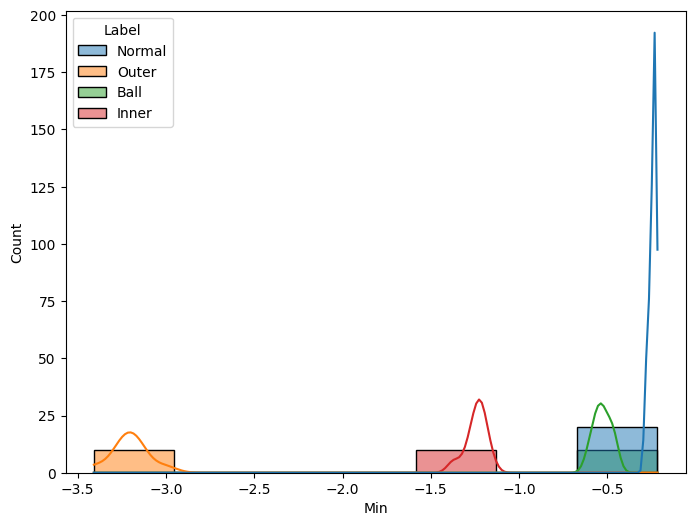

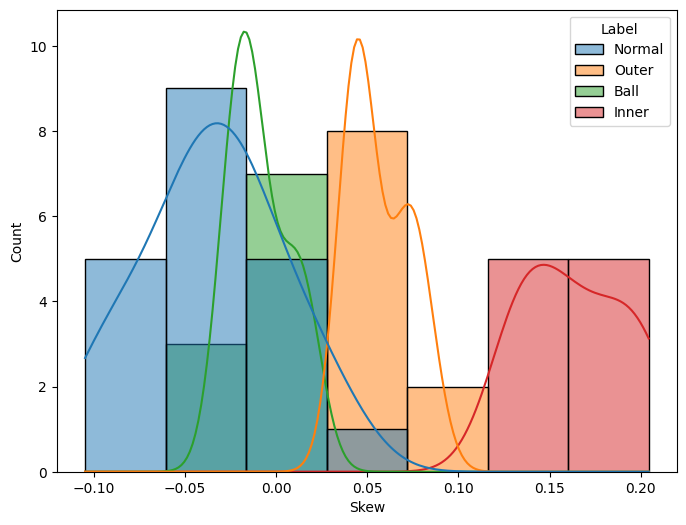

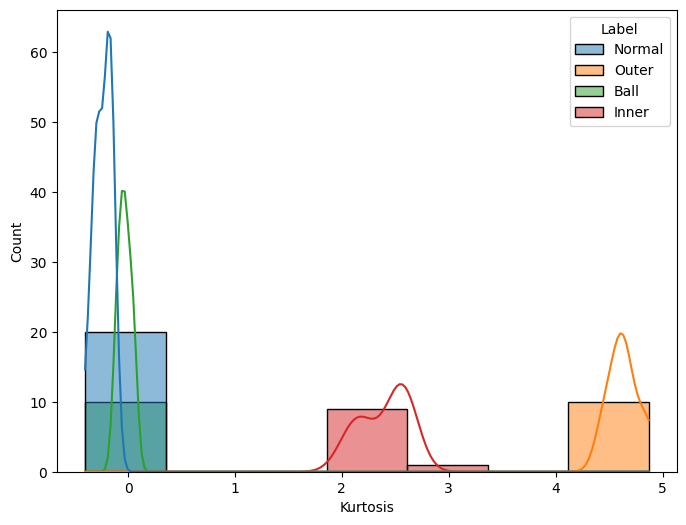

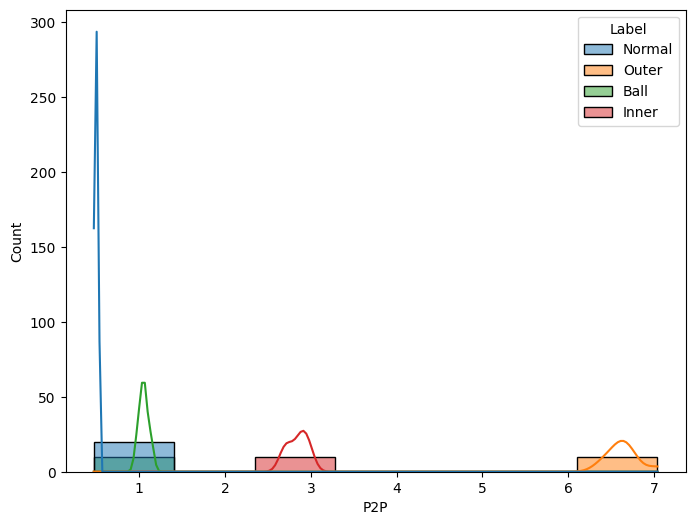

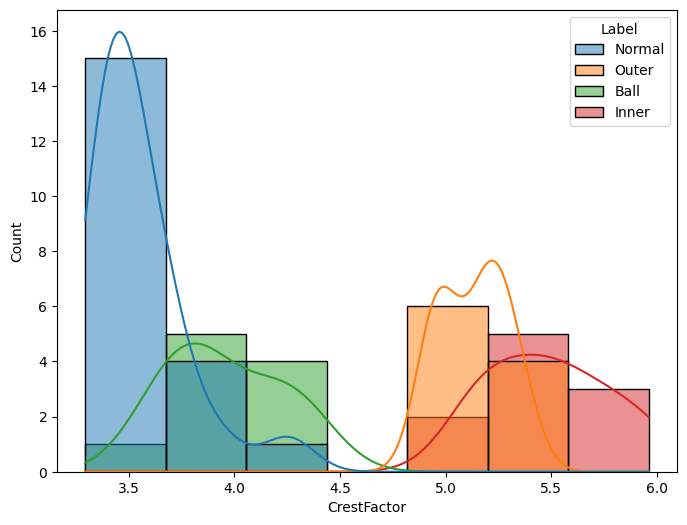

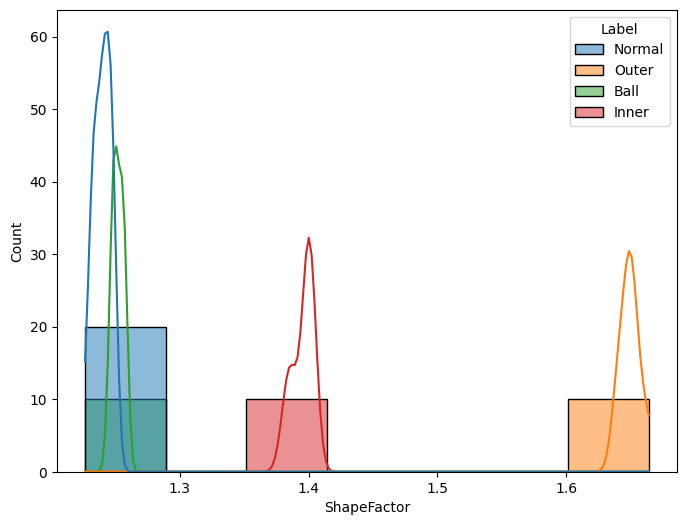

['Ball']
10


In [39]:
# ------ADDITIONAL CODE TO CHECK THE DATA IN CSV FILE AND PERFROM GRAPH FUNCTIONS------


df_all = pd.read_csv('/content/drive/MyDrive/AI_Project/Data/all_data.csv')

df_all.head()
df_all.info()
df_all.describe()
print(df_all['Label'].value_counts())
print(df_all['Label'].unique())

features1 = ['Mean', 'Std', 'RMS', 'Max', 'Min', 'Skew', 'Kurtosis', 'P2P', 'CrestFactor', 'ShapeFactor']
for feature in features1:
  plt.figure(figsize=(8, 6))
  sns.boxplot(x='Label', y=feature, data=df_all)
  plt.show()

features2 = ['Mean', 'Std', 'RMS', 'Max', 'Min', 'Skew', 'Kurtosis', 'P2P', 'CrestFactor', 'ShapeFactor']
for feature in features2:
  plt.figure(figsize=(8, 6))
  sns.histplot(data=df_all, x=feature, hue='Label', kde=True)
  plt.show()

train_df = df_all[df_all['Label'] != 'Ball']
test_df = df_all[df_all['Label'] == 'Ball']

X_train = train_df.drop('Label', axis=1)
X_test = test_df.drop('Label', axis=1)

print(test_df['Label'].unique())
print(len(test_df))


In [46]:
df_all = pd.read_csv('/content/drive/MyDrive/AI_Project/Data/all_data.csv')
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
Y_train = encoder.fit_transform(df_all['Label'])
Y_test = [3] * len(test_df)
print("Class Mapping" , dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))
print("First 10 encoded labels:", Y_test[:10])

Class Mapping {'Ball': np.int64(0), 'Inner': np.int64(1), 'Normal': np.int64(2), 'Outer': np.int64(3)}
First 10 encoded labels: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [48]:
# ------ENCODE LABEL ------
X = df_all.drop('Label', axis=1)
Y = encoder.transform(df_all['Label'])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=20, stratify = Y)


In [43]:
#------ STRATIFIED GROUP K-FOLD ------
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=20)


rf_accuracies = []
svm_accuracies = []
fold = 1

rf_all_pred = []
svm_all_pred = []
true_all = []

def print_once():
    print(f"{'Fold':<6}{'SVM Accuracy':<15}{'RF Accuracy':<15}")

print_once()

for train_index, test_index in skf.split(X, Y, groups=df_all.index):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  Y_train, Y_test = Y[train_index], Y[test_index]


  #Random Forest

  rf = RandomForestClassifier(n_estimators=100, random_state=20)
  rf.fit(X_train, Y_train)
  y_pred_rf = rf.predict(X_test)
  accuracy_rf = accuracy_score(Y_test, y_pred_rf)
  rf_accuracies.append(accuracy_rf)
  rf_all_pred.extend(y_pred_rf)



  #SVM with scaling

  scaler = StandardScaler()
  X_train_svm = scaler.fit_transform(X_train)
  X_test_svm = scaler.transform(X_test)

  svm = SVC(class_weight = 'balanced')
  svm.fit(X_train_svm, Y_train)
  y_pred_svm = svm.predict(X_test_svm)

  accuracy = accuracy_score(Y_test, y_pred_svm)
  svm_accuracies.append(accuracy)
  svm_all_pred.extend(y_pred_svm)

  true_all.extend(Y_test)


  print(f"{fold:<6}{accuracy:<15}{accuracy_rf:<4}")
  fold += 1

print("\nFinal Result ------>")
print("Random Forest Average Accuracy: ", np.mean(rf_accuracies))
print("SVM Average Accuracy: ", np.mean(svm_accuracies))


print("\n Final SVM report on all folds: ")
print(classification_report(true_all, svm_all_pred, zero_division = 0))
print("\n Confusion Matrix: \n", confusion_matrix(true_all, svm_all_pred))

print("\n Final RF report on all folds: ")
print(classification_report(true_all, rf_all_pred, zero_division = 0))
print("\n Confusion Matrix: \n", confusion_matrix(true_all, rf_all_pred))



Fold  SVM Accuracy   RF Accuracy    
1     1.0            1.0 
2     1.0            1.0 
3     1.0            1.0 
4     1.0            1.0 
5     0.9            1.0 

Final Result ------>
Random Forest Average Accuracy:  1.0
SVM Average Accuracy:  0.9800000000000001

 Final SVM report on all folds: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00        10
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        10

    accuracy                           0.98        50
   macro avg       0.98      0.99      0.98        50
weighted avg       0.98      0.98      0.98        50


 Confusion Matrix: 
 [[10  0  0  0]
 [ 0 10  0  0]
 [ 1  0 19  0]
 [ 0  0  0 10]]

 Final RF report on all folds: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00     

In [36]:
df_all = pd.read_csv('/content/drive/MyDrive/AI_Project/Data/all_data.csv')

x = df_all.drop('Label', axis=1)
y = df_all['Label']

encoder = LabelEncoder()
y = encoder.fit_transform(y)

rf_model = RandomForestClassifier(n_estimators=100, random_state=20)
rf_model.fit(x, y)

RandomForestClassifier(random_state=20)

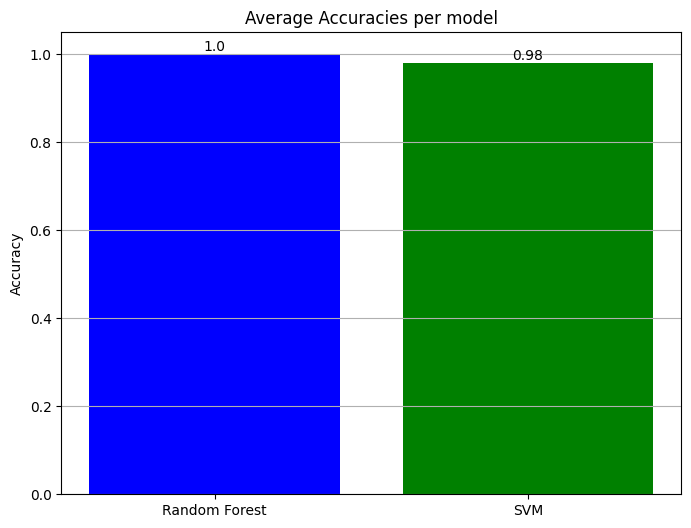

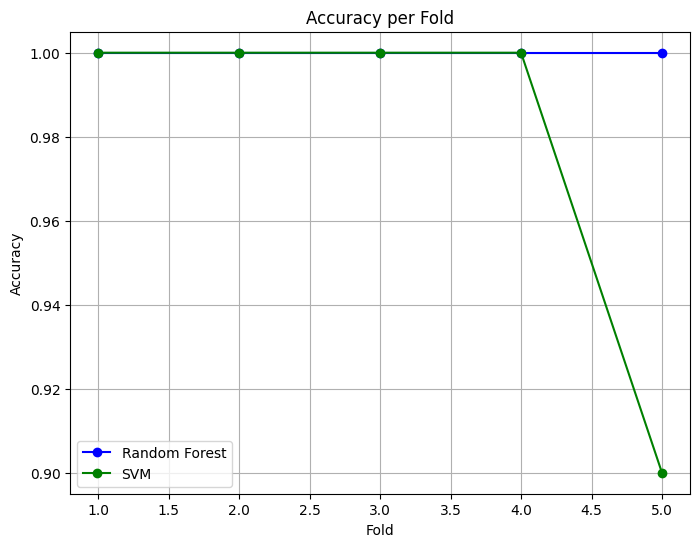

In [37]:


models = ['Random Forest', 'SVM']
accuracies = [np.mean(rf_accuracies), np.mean(svm_accuracies)]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('Average Accuracies per model')
plt.grid(axis='y')
plt.show()


folds = range(1,6)

plt.figure(figsize=(8, 6))
plt.plot(folds, rf_accuracies, marker='o', linestyle='-', color='blue', label='Random Forest')
plt.plot(folds, svm_accuracies, marker='o', linestyle='-', color='green', label='SVM')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold')
plt.legend()
plt.grid(True)
plt.show()

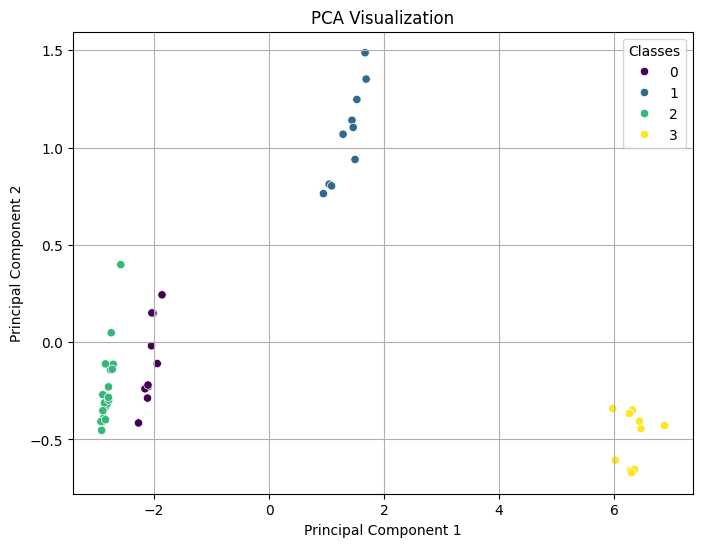

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


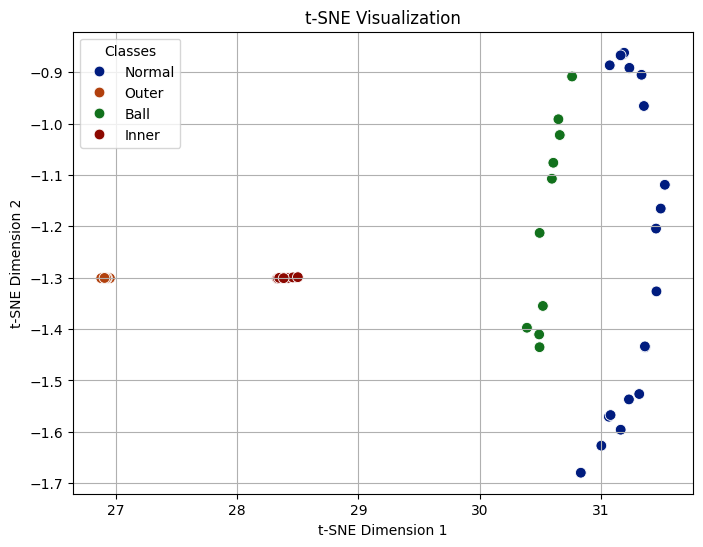

In [26]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Classes')
plt.grid(True)
plt.show()


tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=20)
X_tsne = tsne.fit_transform(x)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue = encoder.inverse_transform(y), palette='dark' ,s=60)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Classes')
plt.grid(True)
plt.show()

In [27]:
!pip install joblib

import joblib

joblib.dump(rf_model, '/content/drive/MyDrive/AI_Project/Code_joblib/rf_model.joblib')
joblib.dump(encoder, '/content/drive/MyDrive/AI_Project/Code_joblib/encoder.joblib')
joblib.dump(scaler, '/content/drive/MyDrive/AI_Project/Code_joblib/svm_model.joblib')

['/content/drive/MyDrive/AI_Project/Code_joblib/svm_model.joblib']